In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from expiry_day_logic import generate_expiry_day_trades

In [2]:
df = pd.read_csv("nifty_intraday_15m_cleaned.csv", parse_dates=["Datetime", "date"])
df.head()

,Datetime,Close,High,Low,Open,Volume,date,time
0,2025-05-19 09:15:00+05:30,280.070007,280.679993,279.609985,280.209991,275073.0,2025-05-19,09:15:00
1,2025-05-19 09:30:00+05:30,279.970001,280.540009,279.709991,280.100006,314377.0,2025-05-19,09:30:00
2,2025-05-19 09:45:00+05:30,280.010010,280.239990,279.910004,280.000000,162601.0,2025-05-19,09:45:00
3,2025-05-19 10:00:00+05:30,280.450012,280.470001,280.040009,280.100006,161882.0,2025-05-19,10:00:00
4,2025-05-19 10:15:00+05:30,280.339996,280.600006,280.179993,280.450012,211431.0,2025-05-19,10:15:00


In [21]:
# Generate trades using strategy
trades_df = generate_expiry_day_trades(df, entry_threshold=0.003, exit_time_str='15:15:00', target_return=0.004, stop_loss=0.005)
print("Generated trades:")
print(trades_df)

trades_df.to_csv("expiry_trades.csv", index=False)
print("Saved generated trades to expiry_trades.csv")

Generated trades:
        date direction entry_time  entry_price exit_time  exit_price    return
0 2025-05-22      long   09:30:00   275.549988  15:15:00  276.220001  0.002432
1 2025-06-05     short   09:30:00   277.640015  15:15:00  278.049988 -0.001477
2 2025-06-26     short   09:30:00   284.450012  13:45:00  285.929993 -0.005203
Saved generated trades to expiry_trades.csv


In [22]:
trades = pd.read_csv("expiry_trades.csv", parse_dates=["date"])
# trades['entry_time'] = pd.to_datetime(trades['entry_time'], format="%H:%M:%S").dt.time
# trades['exit_time'] = pd.to_datetime(trades['exit_time'], format="%H:%M:%S").dt.time
trades.head()

,date,direction,entry_time,entry_price,exit_time,exit_price,return
0,2025-05-22,long,09:30:00,275.549988,15:15:00,276.220001,0.002432
1,2025-06-05,short,09:30:00,277.640015,15:15:00,278.049988,-0.001477
2,2025-06-26,short,09:30:00,284.450012,13:45:00,285.929993,-0.005203


In [23]:
trades['outcome'] = trades['return'].apply(lambda x: 'Win' if x > 0 else 'Loss')
trades['cum_return'] = (1 + trades['return']).cumprod()

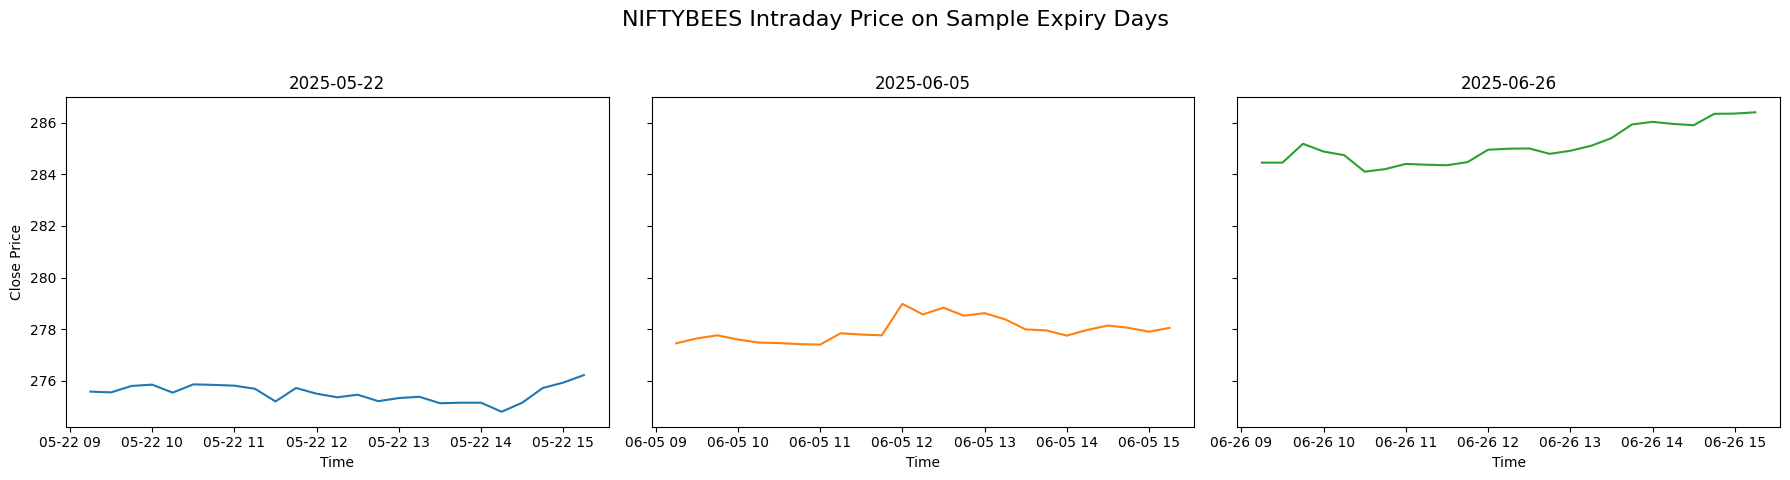

In [24]:

sample_days = trades['date'].sample(min(3, len(trades)), random_state=42)
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, day in enumerate(sample_days):
    ax = axes[i]
    day_data = df[df['date'] == pd.to_datetime(day)]
    
    ax.plot(day_data['Datetime'], day_data['Close'], color=f"C{i}")
    ax.set_title(f"{day.date()}")
    ax.set_xlabel("Time")
    if i == 0:
        ax.set_ylabel("Close Price")

plt.suptitle("NIFTYBEES Intraday Price on Sample Expiry Days", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


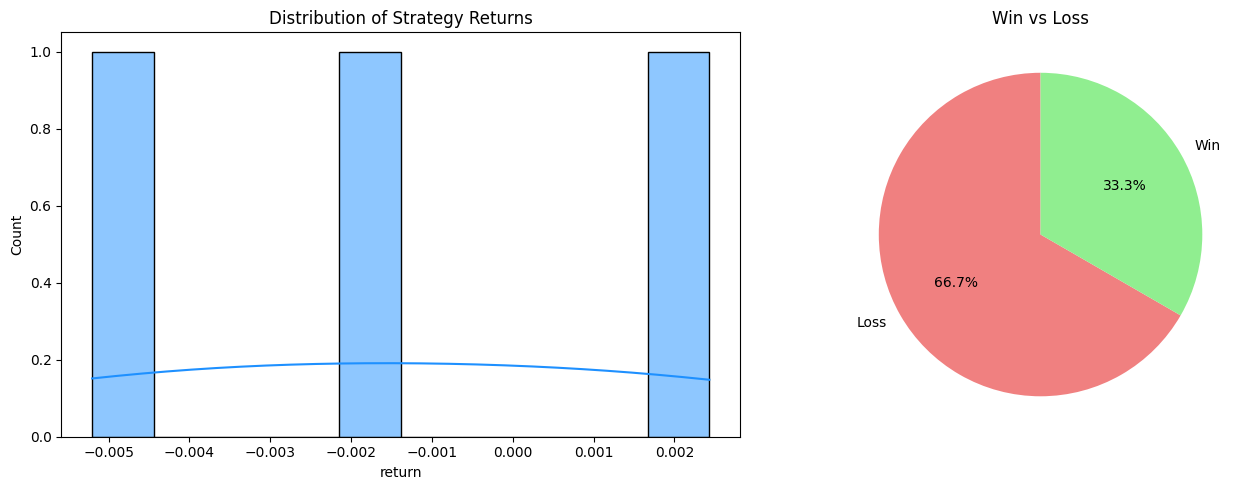

In [25]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.histplot(trades['return'], bins=10, kde=True, color="dodgerblue")
plt.title("Distribution of Strategy Returns")

plt.subplot(1, 2, 2)
trades['outcome'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightgreen'])
plt.title("Win vs Loss")
plt.ylabel("")

plt.tight_layout()
plt.show()

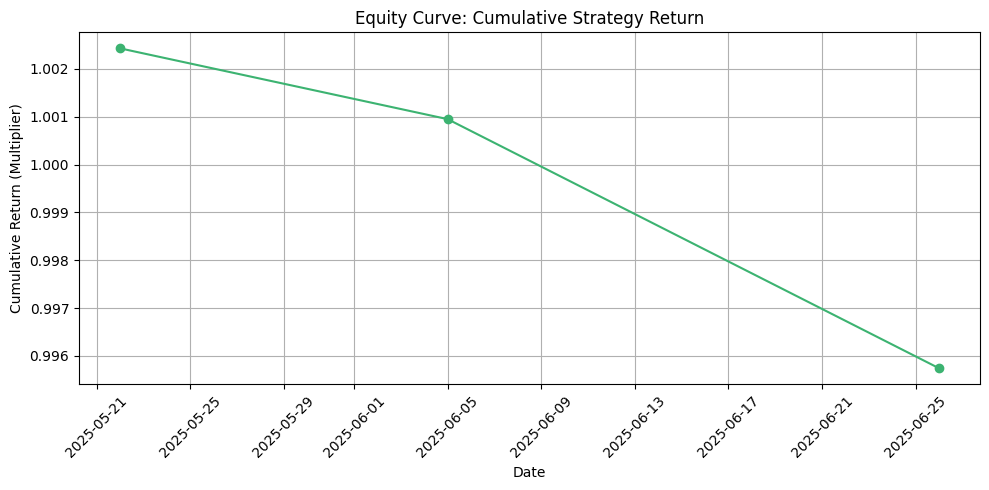

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(trades['date'], trades['cum_return'], marker='o', color='mediumseagreen')
plt.title("Equity Curve: Cumulative Strategy Return")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (Multiplier)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [27]:
summary = {
    "Total Trades": len(trades),
    "Win Rate": (trades['return'] > 0).mean(),
    "Mean Return": trades['return'].mean(),
    "Std Dev": trades['return'].std(),
    "Cumulative Return": trades['cum_return'].iloc[-1] if not trades.empty else 1.0,
    "Sharpe Ratio (naive)": trades['return'].mean() / trades['return'].std() if trades['return'].std() != 0 else None
}

summary_df = pd.DataFrame.from_dict(summary, orient='index', columns=["Value"])
print("Strategy Summary:")
display(summary_df)


Strategy Summary:


,Value
Total Trades,3.000000
Win Rate,0.333333
Mean Return,-0.001416
Std Dev,0.003818
Cumulative Return,0.995743
Sharpe Ratio (naive),-0.370916
